In [ ]:
# 挂载自己的Google 
! pip install google.colab
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import tabulate

from IPython.core.display import HTML
import matplotlib.pyplot as plt
import pdb

## a. Questions: 
> What is the feature of interest? Describe in detail how you selected the images based on the feature of interest and on features of no interest.

> answer: the mouth curve

# Data pre-processing

### Load the data in your analysis environment of choice (Matlab, Python, ...)

**finish 3."Run the experiment" and 4.a**

In [3]:
# filename=r'/content/drive/Othercomputers/我的 MacBook Pro/Desktop/02458/results.txt'
# filename=r'/Users/baixiang/Desktop/02458/results.csv'
filename = '/Users/francis/Desktop/DTU/classes/02458/Stimulus presentation script/results.txt'
attributeNames = ['subject_id','trial_number','stimulus_filename','answer','reaction_time']
result = ['Not smiling','Smiling']
result_dits = [0, 1]
df = pd.read_csv(filename, names = attributeNames)
train_data = df.values
# show DataFrame data, only 5 head items and 5 tail items
display(df.head(5), df.tail(5))
# show Numpy data, only first 10 rows
display(HTML(tabulate.tabulate(train_data[:9], headers=attributeNames, showindex='always', tablefmt='html')))

,subject_id,trial_number,stimulus_filename,answer,reaction_time
0,213,1,ARimage29.png,Smiling,2.5074
1,213,2,ARimage107.png,Not smiling,0.8390
2,213,3,ARimage146.png,Not smiling,0.6857
3,213,4,ARimage244.png,Smiling,0.7164
4,213,5,ARimage276.png,Not smiling,0.7076


,subject_id,trial_number,stimulus_filename,answer,reaction_time
889,213120,294,ARimage68.png,Smiling,0.7244
890,213120,295,ARimage200.png,Not smiling,0.8023
891,213120,296,ARimage103.png,Not smiling,0.5948
892,213120,297,ARimage172.png,Smiling,0.6943
893,213120,298,ARimage211.png,Smiling,0.6674


,subject_id,trial_number,stimulus_filename,answer,reaction_time
0,213,1,ARimage29.png,Smiling,2.5074
1,213,2,ARimage107.png,Not smiling,0.839
2,213,3,ARimage146.png,Not smiling,0.6857
3,213,4,ARimage244.png,Smiling,0.7164
4,213,5,ARimage276.png,Not smiling,0.7076
5,213,6,ARimage97.png,Not smiling,0.6863
6,213,7,ARimage168.png,Not smiling,0.9747
7,213,8,ARimage270.png,Not smiling,0.8137
8,213,9,ARimage264.png,Not smiling,1.1978


### Consider removing outliers for the reaction time (above several seconds, below 200ms)

**finish 4.b**

There are two method:
1. if values > μ + 3σ and values < μ—3σ, I suppose they are outliers
2. if values > 1s and values < 200ms, I suppose they are outliers (from the project instruction)

I choose the second one, cause it's seems really efficient

In [4]:
mean = train_data[:,4].mean()                   # caluate the mean of the data we collected

std  = train_data[:,4].std()                    # caluate the Standard deviation of the data we collected

# 看有多少个测试者
observer_ID = sorted(set(train_data[:,0]))      # abstract the observer's ID
# observer_ID = np.unique(train_data[:,0])
print("observer_ID",observer_ID)

N = len(observer_ID)                            # count the amount of observer involved in our experiment

# show them all
print('There are', N, 'observers in the train dataset')
print('And they are', observer_ID)
print('The average reaction time of all the observers is', mean, 's, and the variance is', std)

# define the outlier threshod
upper_threshod, lower_threshod = 1, 0.2

'''clean the data, weed out outliers'''
X = []  # empty list to save the cleaned data

# counter of outliers
outliter = 0
for i in range(len(train_data[:,0])):
  if  lower_threshod < train_data[i,4] < upper_threshod:
    X.append(train_data[i])
  else:
    outliter += 1
print('There are', outliter, 'outliers in our data')

# '''show fist 10 rows of cleaned data X'''
display(HTML(tabulate.tabulate(X[:9], headers=attributeNames, showindex='always', tablefmt='html')))


observer_ID [213, 623, 213120]
There are 3 observers in the train dataset
And they are [213, 623, 213120]
The average reaction time of all the observers is 0.9465923937360174 s, and the variance is 0.9675626557172228
There are 197 outliers in our data


,subject_id,trial_number,stimulus_filename,answer,reaction_time
0,213,2,ARimage107.png,Not smiling,0.839
1,213,3,ARimage146.png,Not smiling,0.6857
2,213,4,ARimage244.png,Smiling,0.7164
3,213,5,ARimage276.png,Not smiling,0.7076
4,213,6,ARimage97.png,Not smiling,0.6863
5,213,7,ARimage168.png,Not smiling,0.9747
6,213,8,ARimage270.png,Not smiling,0.8137
7,213,10,ARimage92.png,Smiling,0.6519
8,213,11,ARimage36.png,Not smiling,0.7939


**part of 4.c**

In [5]:
'''coding the face emotion results smelling and not smelling to digits'''
X = np.array(X)
for i in range(len(X[:,0])):
  if X[i,3] == 'Smiling':
    X[i,3] = 1
  else:
    X[i,3] = 0

# '''show fist 10 rows of cleaned data X'''
display(HTML(tabulate.tabulate(X[:9], headers=attributeNames, showindex='always', tablefmt='html')))

,subject_id,trial_number,stimulus_filename,answer,reaction_time
0,213,2,ARimage107.png,0,0.839
1,213,3,ARimage146.png,0,0.6857
2,213,4,ARimage244.png,1,0.7164
3,213,5,ARimage276.png,0,0.7076
4,213,6,ARimage97.png,0,0.6863
5,213,7,ARimage168.png,0,0.9747
6,213,8,ARimage270.png,0,0.8137
7,213,10,ARimage92.png,1,0.6519
8,213,11,ARimage36.png,0,0.7939


### Normalise the reaction times for each person and then pool them into one data set.
**finish 4.c**
There are many kinds of normalise methods:
1. z = (x - u) / s
2. z = (x - u)

In [6]:
plt.rcParams['figure.dpi'] = 200  # setting the 
# names = locals()
names = {}
for i in range(N):
  names['observer' + str(i)] = []


for j in range(len(X[:,0])):
  for i in range(N):
    # Zhijian Feng 21.30.21.05
    # if X[j,0] == observor_ID[i]:
    if X[j,0] == observer_ID[i]:
      names['observer' + str(i)].append(X[j])

# convert the list to numpy array and Normalization
for i in range(N):
  names['observer' + str(i)] = np.array(names['observer' + str(i)])
  tmp_mean = names['observer' + str(i)][:,4].mean()
  tmp_std = names['observer' + str(i)][:,4].std()
  temp_normal = ((names['observer' + str(i)][:,4]- tmp_mean) / tmp_std)
  temp_normal = np.reshape(temp_normal,(len(temp_normal),1))
  names['observer' + str(i)] = np.hstack((names['observer' + str(i)],temp_normal))

# print(names['observer0'][:,1])
# 现在整个数据结构就是，names这个dict用来存所有的数据，里面用 “observer$num.format(test_number,%d)" 来索引每一个用户。
# 然后里面每一个observer里面的结构是一个二维数组，保持原来的特性 
# 二维数组的属性：subject_id, trial_number, stimulus_filename, answer, reaction_time, normal_value

# process normalization in time feature [4]

# time = [value[:,4] for key,value in names.items()]
# pdb.set_trace()
time = {}
my_split_time = {}
all_train = []
for key,value in names.items():
  ab_value = value[:,4]
  mean = ab_value.mean()
  std = ab_value.std()
  time[key] = (ab_value - mean) /std
  if key == 'observer0':

    smile_idx = np.where(names[key][:,3] == 1)
    not_smile_idx = np.where(names[key][:,3] == 0)

    max_smile, min_smile = max(ab_value[smile_idx]),min(ab_value[smile_idx])
    max_not_smile, min_not_smile = max(ab_value[not_smile_idx]),min(ab_value[not_smile_idx])

    my_split_time['not_smile'] = - ((ab_value[not_smile_idx] - min_not_smile) / (max_not_smile-min_not_smile))
    my_split_time['smile'] = ((ab_value[smile_idx] - min_smile) / (max_smile-min_smile))

    for i in range(len(smile_idx[0])):
      img_name = names[key][i,2]
      reac_time = my_split_time['smile'][i]
      all_train.append( [img_name,reac_time] )
    
    for i in range(len(not_smile_idx[0])):
      img_name = names[key][i,2]
      reac_time = my_split_time['not_smile'][i]
      all_train.append( [img_name,reac_time] )




# Vectorization_time = 

# for i in range(N):
#   # names['observer' + str(i)] = np.array(names['observer' + str(i)])
#   # observer_mean = names['observer' + str(i)][:,4].mean()
#   # observer_std = names['observer' + str(i)][:,4].std()
#   # names['observer' + str(i) + '_normal'] = ((names['observer' + str(i)][:,4]- observer_mean) / observer_std).flatten()
#   # print(names['observer' + str(i) + '_normal'].shape)
#   # print(names['observer' + str(i) + '_normal'].flatten())
#   plt.subplot(1, N, i+1)
#   plt.hist(names['observer' + str(i)][:,5], bins=20)
#   # plt.title('observer' + str(i) + '[' + str(observer_ID[i]) + ']')
#   plt.title('observer' + str(i))
#   plt.xlabel('ReactTimeSpan')
#   plt.ylabel('Distribution')
#   plt.tight_layout(pad=0.4, w_pad=1, h_pad=1.0)


**finish 5.a**

In [37]:
import cv2
import os
import pdb

image_path = r'/Users/francis/Desktop/DTU/classes/02458/ARArchive/'
ori_image_size = 50
all_image_values = np.zeros((ori_image_size,ori_image_size),dtype=np.uint16)
# all_image_values = cv2.cvtColor(all_image_values, cv2.COLOR_GRAY2BGR)

ori_imgs = []
# file_list = os.listdir(image_path)
# for f_name in file_list:
#     if f_name == ".DS_Store":
#         continue
#     tmp_path = os.path.join(image_path,f_name)
#     img = cv2.imread(tmp_path,-1)
#     ori_imgs.append(img)
#     # for i in range(3):
#     all_image_values[:,:] = all_image_values[:,:] + img[:,:]


for i in range(len(all_train)):
    img_path = os.path.join(image_path,all_train[i][0])
    img = cv2.imread(img_path,-1)
    h,w = img.shape[:2]
    reshape_img = np.reshape(img,(1,h*w))
    all_image_values += img
    ori_imgs.append(img)


ori_imgs = np.array(ori_imgs)

mean_value = all_image_values / (len(all_train))

ori_imgs = ori_imgs - mean_value

print(ori_imgs.shape)





(201, 50, 50)


[['ARimage107.png', 0.4192867693606246],
 ['ARimage146.png', 0.283182105929521],
 ['ARimage244.png', 0.35577125975944285],
 ['ARimage276.png', 0.5110782865583456],
 ['ARimage97.png', 0.7864528381515086],
 ['ARimage168.png', 0.2757965815572904],
 ['ARimage270.png', 0.3196876978265456],
 ['ARimage92.png', 0.23507069001899122],
 ['ARimage36.png', 0.2219877611310402],
 ['ARimage164.png', 0.18421607934163312],
 ['ARimage62.png', 0.1171133150453682],
 ['ARimage122.png', 0.19687697826545672],
 ['ARimage89.png', 0.25152985861996197],
 ['ARimage80.png', 0.18421607934163312],
 ['ARimage70.png', 0.3918548216923401],
 ['ARimage73.png', 0.8660054863895337],
 ['ARimage117.png', 0.23464866005486382],
 ['ARimage109.png', 0.6138425828233803],
 ['ARimage116.png', 0.338679046212281],
 ['ARimage23.png', 0.8326651192234648],
 ['ARimage131.png', 0.3821481325174086],
 ['ARimage177.png', 0.46613209537877187],
 ['ARimage258.png', 0.6077231483435322],
 ['ARimage259.png', 0.10761764085250039],
 ['ARimage54.png',

**finish5.b**

In [29]:
import scipy
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model


# Obtain the PCA solution  by calculate the SVD of Y

# sequence
sequence_imgs = []
for i in range(len(ori_imgs)):
    sequence_imgs.append(ori_imgs[i].reshape(1,50*50))

sequence_imgs = np.array(sequence_imgs)
d_1,d_2,d_3 = sequence_imgs.shape
sequence_imgs = np.reshape(sequence_imgs,(d_1,d_3))

print(sequence_imgs.shape)

U,S,V = linalg.svd(sequence_imgs,full_matrices=False)
# print(V)
V = V.T
# Compute variance explained by principal components
rho = (S*S) / (S*S).sum() 

# Project data onto principal component space
Z = sequence_imgs @ V

print("U.shape",U.shape)
print("S.shape",S.shape)
print("V.shape",V.shape)
print("Z.shape",Z.shape)


# print("sequence_imgs.shape",sequence_imgs.shape)
# print("Z.shape",Z.shape)

# Plot variance explained
threshold = 0.9
plt.figure()
plt.plot(range(1,len(rho)+1),rho,'-')                  # 绘制各在成分上投影的方差
plt.plot(range(1,len(rho)+1),np.cumsum(rho),'-')       # 绘制各成分累加的可解释变异或课解释方差
plt.plot([1,len(rho)],[threshold, threshold],'-')     # 绘制压缩要求阈值
plt.title('Variance explained by principal components')
plt.xlabel('Principal component')
plt.ylabel('Variance explained')
plt.legend(['Individual','Cumulative','Threshold'])
plt.grid()
plt.show()



(201, 2500)
U.shape (201, 201)
S.shape (201,)
V.shape (2500, 201)
Z.shape (201, 201)


**finish 5.c**


**as we can see the above photo, we choose 100 PCs which can represent 90% raw data**

(2500, 201)


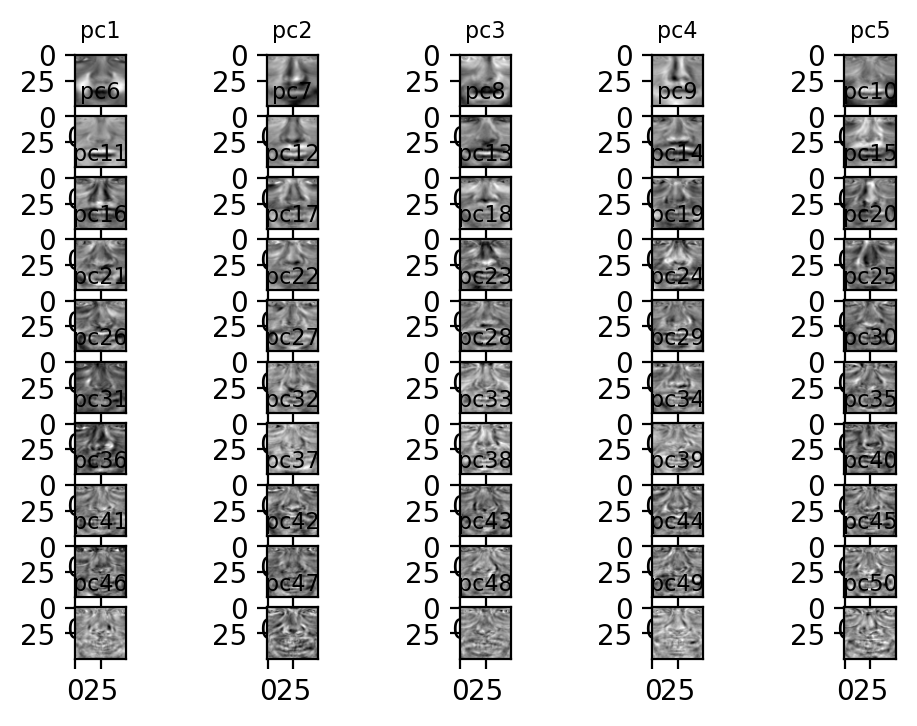

In [30]:
num_of_PCs = 50

# Project data onto principal component space
Z = sequence_imgs @ V[:,:50]


samples_num = V.shape[1]
# V.shape (2500, 298)
# V = V.T
print(V.shape) # -> (2500, 20)

# print(V[:,:num_of_PCs].shape) # -> (2500, 20)

# plt.rcParams['figure.dpi'] = 200

for i in range(V[:,:num_of_PCs].shape[1]):
    # pdb.set_trace()
    pc_img = np.reshape(V[:,i],(ori_image_size,ori_image_size))
    plt.subplot(10,int(num_of_PCs/10),i+1)
    plt.title('pc'+str(i+1),fontsize = 8)
    plt.imshow(pc_img,cmap=plt.cm.gray_r)


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable



# define network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  
        # input layer
        self.FNN = nn.Sequential(
            nn.Linear(in_features = num_of_PCs, out_features = 10),
            nn.Linear(in_features = 10, out_features = 1),
        )

    def forward(self, input):
        x = self.FNN(input)
        return x


net = Net()
criterion = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.5, weight_decay=1e-5)

BATCH_SIZE = 10
num_samples = 289
NUM_EPOCHS = 300

def train_epoch(train_loader):
    Loss = []
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader,0):
        
        # 清上一次求导值
        optimizer.zero_grad()

        # 这一批 BATCH_SIZE 个样本 进网络玩耍
        output = net(data)

        # 计算这一批 BATCH_SIZE 个样本的总loss
        batch_loss = criterion(output, target)
        
        # 反向传播
        batch_loss.backward()

        # 更新权值
        optimizer.step()

        Loss.append(batch_loss.detach().numpy())
    return Loss

def eval_epoch(test_loader):

    EDS = []
    net.eval()
    for data, target in test_loader:
        # 这一批 BATCH_SIZE 个样本 进网络玩耍
        output = net(data)
        batch_loss = criterion(output, target)

        # val = ED(output.detach().numpy(),target.detach().numpy())

        EDS.append(batch_loss.detach().numpy())
        # test_loss = criterion(output,target).item()

    return EDS

def start(train_loader,test_loader):
    valid_accs, train_accs, test_accs = [], [], []
    for i in range(NUM_EPOCHS):
        print("Epoch :",i)
        train_Loss = train_epoch(train_loader)
        test_Loss = eval_epoch(test_loader)
        print("Train Epoch:",i," Loss :",np.mean(train_Loss),"Test_loss:",np.mean(test_Loss))



In [36]:

all_x = torch.from_numpy(Z).float()
all_y = torch.from_numpy(np.array([all_train[i][1] for i in range(len(all_train))])).float()

# pdb.set_trace()
# all_x = torch.from_numpy(all_x_np).float()
# all_y = torch.from_numpy(all_y_np).float()

train_db = torch.utils.data.TensorDataset(all_x,all_y)

train_size = int(0.9 * len(all_x))
test_size = len(all_x) - train_size

train_data,test_data = torch.utils.data.random_split(train_db,[train_size,test_size])

train_loader = torch.utils.data.DataLoader( dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader( dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

# train_dataset, test_dataset = torch.utils.data.random_split(all_x, [train_size, test_size])

start(train_loader,test_loader)

Epoch : 0
Train Epoch: 0  Loss : 47.735733 Test_loss: 24.008926
Epoch : 1
Train Epoch: 1  Loss : 10.694132 Test_loss: 4.7701497
Epoch : 2
Train Epoch: 2  Loss : 3.6664963 Test_loss: 2.6996117
Epoch : 3
Train Epoch: 3  Loss : 4.82409 Test_loss: 2.4502504
Epoch : 4
Train Epoch: 4  Loss : 3.747899 Test_loss: 4.246135
Epoch : 5
Train Epoch: 5  Loss : 3.8343964 Test_loss: 5.758139
Epoch : 6
Train Epoch: 6  Loss : 2.8021426 Test_loss: 3.2280552
Epoch : 7
Train Epoch: 7  Loss : 2.7736092 Test_loss: 4.0551114
Epoch : 8
Train Epoch: 8  Loss : 2.773836 Test_loss: 3.2802105
Epoch : 9
Train Epoch: 9  Loss : 2.4368372 Test_loss: 1.1800352
Epoch : 10
Train Epoch: 10  Loss : 2.4852524 Test_loss: 1.6718076
Epoch : 11
Train Epoch: 11  Loss : 2.3243337 Test_loss: 3.2884872
Epoch : 12
Train Epoch: 12  Loss : 2.6992924 Test_loss: 4.8716865
Epoch : 13
Train Epoch: 13  Loss : 2.848313 Test_loss: 2.6044002
Epoch : 14
Train Epoch: 14  Loss : 2.7075403 Test_loss: 1.19903
Epoch : 15
Train Epoch: 15  Loss : 1.55

**finsih 8.b**

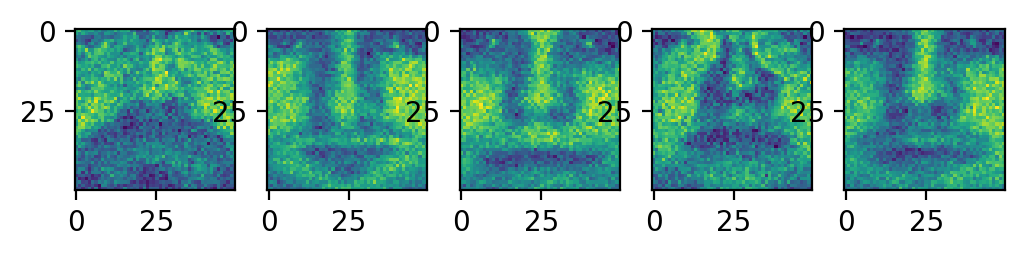

In [414]:
import random
test_idx = [random.randint(0,297) for i in range(5)]
# print(test_idx)

test_x_np = sequence_imgs[test_idx,:]
test_x = torch.from_numpy(test_x_np).float()
test_output = net(test_x)

# V 是网络权重 2500 * 50
V = net.state_dict()['FNN.0.weight'].detach().numpy() # 50*2500
# V = V.T # 2500*50
Z = test_output.detach().numpy() # 5*50 

feature_nums = 100

invert_transfrom = Z[:,:feature_nums] @ V[:feature_nums,:] # 5*2500

for i in range(invert_transfrom.shape[0]):
    plt.subplot(1,5,i+1)
    img = np.reshape(invert_transfrom[i,:],(ori_image_size,ori_image_size)) + mean_value
    plt.imshow(img)


# print(test_output.shape)

# X_img = U * theta * V.T
# 298 * 50 = (298 * 298) * (298,) * (298,50)

# w = Z[:50] @ v[:50]

# W = Z[:,range(K)] @ V[:,range(K)].T # 选取前K个主成分压缩后的数据进行复原
# D = len(nD) # 前面定义了nd = range(6)，即本次要随机复原哪几张图片
# for d in range(D):
#     digit_ix = np.random.randint(0,N)
#     subplot(2, D, d+1) # 为什么要+1，因为subbplot是从1开始计数索引的
#     I = np.reshape(X[digit_ix,:], (16,16))
#     imshow(I, cmap=cm.Blues)
#     title('Original')
#     subplot(2, D, D+d+1) # 复原后图片的展示位置
#     I = np.reshape(W[digit_ix,:]+X.mean(0), (16,16)) # 当时处理原始数据时坐标系归零了
#     imshow(I, cmap=cm.Greens)
#     title('Reconstr.');
# output(50) 就是这个Z
# 网络的权重就是 V.T

# print(net.state_dict()['FNN.0.weight'])
# table = net.state_dict()['FNN.0.weight'].detach().numpy().tolist()
# from IPython.core.display import display, HTML
# from tabulate import tabulate
# display(HTML('<h2>weight(pc vectors)</h2>'+ tabulate(table, tablefmt='html')))



**finish 9**

**根据不同类别（笑和不笑）今天去生成七张图**

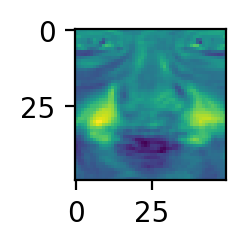

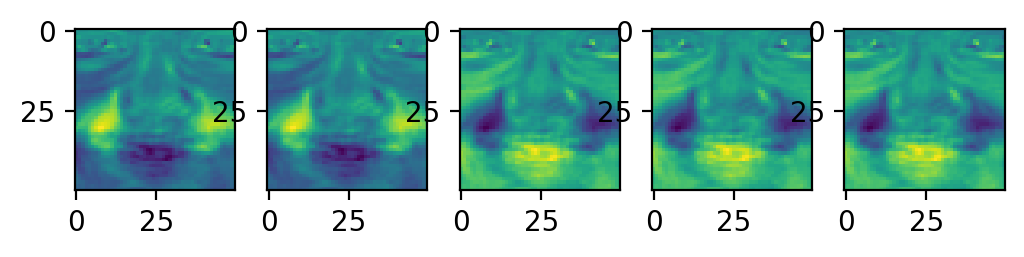

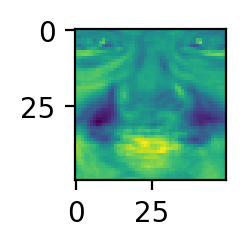

In [60]:
# names.keys()
# # 二维数组的属性：subject_id, trial_number, stimulus_filename, answer, reaction_time, normal_value
# train_data = df.values
# h,w = train_data.shape[:2]
# # 213, 1, 'ARimage29.png', 'Smiling', 2.5074]
# img_root_path = '/Users/francis/Desktop/DTU/classes/02458/ARArchive'

# empty = np.empty((h,1))
# train_data = np.concatenate((train_data,empty),axis=1)

# for i in range(h):
#     path = os.path.join(img_root_path,train_data[i,2])
#     img = cv2.imread(path,-1)
#     train_data[i,w] = img

smile_idx = []
not_smile_idx = []
for key,value in names.items():
    if key == 'observer0':
        for idx,value in enumerate(names[key]):
            # pdb.set_trace()
            if value[3] == 0:
                not_smile_idx.append(idx)
            elif value[3] == 1:
                smile_idx.append(idx)
# pdb.set_trace()

# sequence_imgs.shape 201*2500

smile = (sequence_imgs[smile_idx,:])
not_smile = (sequence_imgs[not_smile_idx,:])


all_smile = np.zeros((1,2500))
for i in range(smile.shape[0]):
    all_smile += smile[i]

mean_smile = np.reshape(all_smile/smile.shape[0],(50,50))

all_not_smile = np.zeros((1,2500))
for i in range(not_smile.shape[0]):
    all_not_smile += not_smile[i]
mean_not_smile = np.reshape(all_not_smile/not_smile.shape[0],(50,50))

pc_nums = 5
diff_smile = (mean_not_smile - mean_smile) / pc_nums  # -> 50 * 50


# from smile to not_smile
plt.figure(figsize=(1,1))
plt.imshow(mean_not_smile)
plt.figure()
for i in range(pc_nums):
    plt.subplot(1,pc_nums,i+1)
    tmp_img = mean_not_smile - diff_smile * i
    plt.imshow(tmp_img)
plt.figure(figsize=(1,1))
plt.imshow(mean_smile)



**用PCA生成7副图**

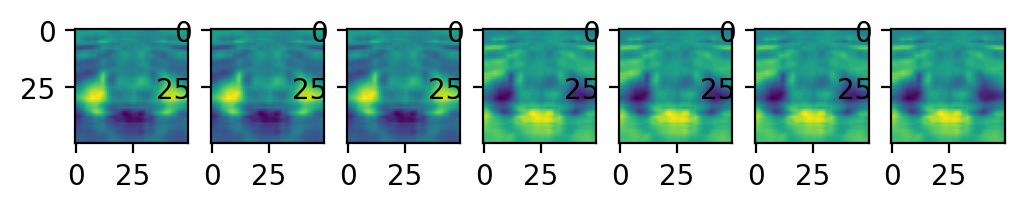

In [74]:
# PCA

# Vectorization
vec_smile = all_smile
vec_not_smile = all_not_smile

# mean_img
# mean_smile and mean_not_smile

U_s,S_s,V_s = linalg.svd(mean_smile,full_matrices=False)
V_s = V_s.T
# Compute variance explained by principal components
rho_s = (S_s*S_s) / (S_s*S_s).sum() 
# Project data onto principal component space
Z_s = mean_smile @ V_s

# # Plot variance explained
# threshold = 0.9
# plt.figure(figsize=(5,5))
# plt.plot(range(1,len(rho_s)+1),rho_s,'-')                  # 绘制各在成分上投影的方差
# plt.plot(range(1,len(rho_s)+1),np.cumsum(rho_s),'-')       # 绘制各成分累加的可解释变异或课解释方差
# plt.plot([1,len(rho_s)],[threshold, threshold],'-')     # 绘制压缩要求阈值
# plt.title('Variance explained in Smile')
# plt.xlabel('Principal component')
# plt.ylabel('Variance explained')
# plt.legend(['Individual','Cumulative','Threshold'])
# plt.grid()
# plt.show()

U_ns,S_ns,V_ns = linalg.svd(mean_not_smile,full_matrices=False)
V_ns = V_ns.T
# Compute variance explained by principal components
rho_ns = (S_ns*S_ns) / (S_ns*S_ns).sum() 
# Project data onto principal component space
Z_ns = mean_not_smile @ V_ns

# # Plot variance explained
# threshold = 0.9
# plt.figure(figsize=(5,5))
# plt.plot(range(1,len(rho_ns)+1),rho_ns,'-')                  # 绘制各在成分上投影的方差
# plt.plot(range(1,len(rho_ns)+1),np.cumsum(rho_ns),'-')       # 绘制各成分累加的可解释变异或课解释方差
# plt.plot([1,len(rho_ns)],[threshold, threshold],'-')     # 绘制压缩要求阈值
# plt.title('Variance explained in Not Smile')
# plt.xlabel('Principal component')
# plt.ylabel('Variance explained')
# plt.legend(['Individual','Cumulative','Threshold'])
# plt.grid()
# plt.show()

smile_feature_num = 5
not_smile_feature_num = 5

Z_s = mean_smile @ V_s
Z_ns = mean_not_smile @ V_ns

deconstruction_smile = Z_s[:,range(smile_feature_num)] @ V_s[:,range(smile_feature_num)].T
deconstruction_not_smile = Z_ns[:,range(not_smile_feature_num)] @ V_ns[:,range(not_smile_feature_num)].T

# plt.figure(figsize=(1,1))
# plt.imshow(deconstruction_smile)
# plt.figure(figsize=(1,1))
# plt.imshow(deconstruction_not_smile)

pho_nums = 7
diff_pca_img = (deconstruction_not_smile - deconstruction_smile) / pho_nums
plt.figure()
for i in range(pho_nums):
    plt.subplot(1,pho_nums,i+1)
    tmp_img = deconstruction_not_smile - diff_pca_img * i
    plt.imshow(tmp_img)


